In [85]:
import matplotlib.pyplot as plt
import pandas as pd
#import talib
import numpy as np
import lightgbm as lgb
import pyfolio as pf
import time
start_time = time.time()

In [86]:
#import tensorflow-gpu

In [87]:
import tensorflow as tf


In [88]:
print(len(tf.config.experimental.list_physical_devices('GPU')) )

0


In [89]:
from tensorflow.python.client import device_lib

In [90]:
print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10049274581796243132
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10610239461874206242
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15177159165240610212
physical_device_desc: "device: XLA_GPU device"
]


In [91]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [92]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [93]:
#Step1 Get Original Data from Interactivebroker
# filename = "SPY_20040123_20200529_30min.csv" #from IB
filename = "quandl_N4N_5D_20071001~20200313.csv" #from IB
df = pd.read_csv(filename,index_col = 0)
# df.reset_index(drop=True,inplace=True)
print(df.shape)
print(df.head(1))
print(df.tail(1))

(5334, 21)
            SPF  DJF  Oil  GOLD  USD  TBF  TN5      SPFy  SPFclose  DJFy  ...  \
Date                                                                      ...   
2000-01-04  NaN  NaN  NaN   NaN  NaN  NaN  NaN  1.030103    1411.8   NaN  ...   

               GOLDy  GOLDclose      Oily  Oilclose      USDy  USDclose  \
Date                                                                      
2000-01-04  1.002664      281.5  1.008611     25.55  1.001598     100.1   

                TBFy  TBFclose      TN5y   TN5close  
Date                                                 
2000-01-04  0.984828    90.625  0.993776  97.914062  

[1 rows x 21 columns]
                 SPF       DJF       Oil  GOLD       USD       TBF       TN5  \
Date                                                                           
2020-06-12  0.008139  0.014743 -0.002201   NaN  0.005851 -0.006598 -0.000745   

            SPFy  SPFclose  DJFy  ...  GOLDy  GOLDclose  Oily  Oilclose  USDy  \
Date        

In [94]:
#Step2 check data

#Check NAN
print(df.isnull().values.any() )
print("before dropping NaN", df.shape)
df.dropna(inplace=True)
print("after dropping NaN", df.shape)

# print( df.info() )
print(type(df.index[0]), df.index[0])
df.index = pd.to_datetime(df.index)
# print( df.info() )
print(type(df.index[0]), df.index[0])

True
before dropping NaN (5334, 21)
after dropping NaN (3097, 21)
<class 'str'> 2007-10-02
<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2007-10-02 00:00:00


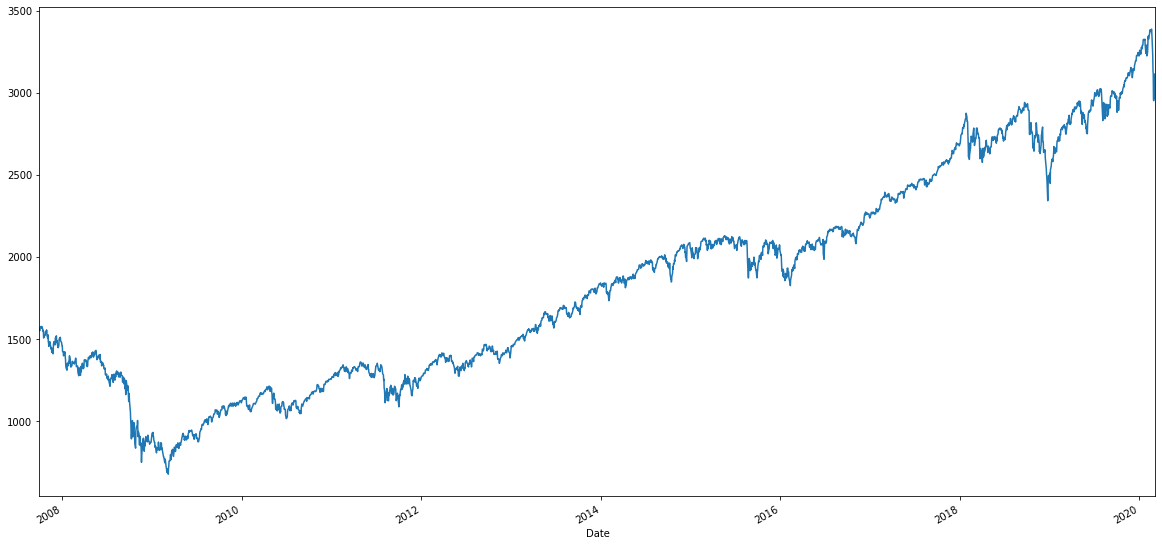

In [95]:
#Step Clean Data
# tc=df.close #targetclose
tc=df.SPFclose #targetclose
plt.rcParams["figure.figsize"] = (20,10)
tc.plot()

In [96]:
# Feature 

In [97]:

%%time 
#Wall time: 4.09 s
import numpy as np
import tqdm

time_period = 200

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.tqdm_notebook(range(0, len(tc) - time_period - 1 - 11, 3)):
    s = tc.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    r = tc.iloc[i+time_period+10] / tc.iloc[i+time_period-1]
    cnn_y.append(r)
    indexs.append(tc.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)






CPU times: user 140 ms, sys: 12.4 ms, total: 152 ms
Wall time: 140 ms


Reshape features and labels

In [98]:
# cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_x = cnn_x.reshape(len(cnn_x), 20,10, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)

In [99]:
# import talib
# import numpy as np
# import pandas as pd

# sma = talib.SMA(tc, timeperiod=120)
# wma = talib.WMA(tc, timeperiod=120)
# mom = talib.MOM(tc, timeperiod=120)
# k, d = talib.STOCH  (tc, tc, tc, fastk_period=120, slowk_period=60, slowd_period=60)
# k2, d2 = talib.STOCH(tc, tc, tc, fastk_period=240, slowk_period=120, slowd_period=120)
# k3, d3 = talib.STOCH(tc, tc, tc, fastk_period=360, slowk_period=180, slowd_period=180)
# k4, d4 = talib.STOCH(tc, tc, tc, fastk_period=480, slowk_period=240, slowd_period=240)
# k5, d5 = talib.STOCH(tc, tc, tc, fastk_period=640, slowk_period=320, slowd_period=320)
# k6, d6 = talib.STOCH(tc, tc, tc, fastk_period=720, slowk_period=360, slowd_period=360)
# k7, d7 = talib.STOCH(tc, tc, tc, fastk_period=840, slowk_period=420, slowd_period=420)
# k8, d8 = talib.STOCH(tc, tc, tc, fastk_period=960, slowk_period=480, slowd_period=480)

# rsi = talib.RSI (tc, timeperiod=120)
# rsi2 = talib.RSI(tc, timeperiod=240)
# rsi3 = talib.RSI(tc, timeperiod=480)
# rsi4 = talib.RSI(tc, timeperiod=640)
# rsi5 = talib.RSI(tc, timeperiod=720)
# rsi6 = talib.RSI(tc, timeperiod=840)

# macd1, macd2, macd3 = talib.MACD(tc, fastperiod=120, slowperiod=60, signalperiod=60)
# willr = talib.WILLR(tc, tc, tc, timeperiod=120)
# cci = talib.CCI(tc, tc, tc, timeperiod=120)

# dataset = pd.DataFrame({
#     'RSIb': rsi / 50,
#     'RSIb2': rsi2 / 50,
#     'RSIb3': rsi3 / 50,
#     'RSIb4': rsi4 / 50,
#     'RSIb5': rsi5 / 50,
#     'RSIb6': rsi6 / 50,
#     'MOMb': mom - 0,
#     'KDb': k - d,
#     'KDb2': k2 - d2,
#     'KDb3': k3 - d3,
#     'KDb4': k4 - d4,
#     'KDb5': k5 - d5,
#     'KDb6': k6 - d6,
#     'KDb7': k7 - d7,
#     'KDb8': k8 - d8,
    
#     'a5':   (tc.rolling(5).mean()   / tc),
#     'a10':  (tc.rolling(10).mean()  / tc),
#     'a20':  (tc.rolling(20).mean()  / tc),
#     'a40':  (tc.rolling(40).mean()  / tc),
#     'a80':  (tc.rolling(80).mean()  / tc),
#     'a160': (tc.rolling(160).mean() / tc),
#     'a320': (tc.rolling(320).mean() / tc),
#     'a640': (tc.rolling(640).mean() / tc),
#     'a720': (tc.rolling(720).mean() / tc),
#     'a840': (tc.rolling(840).mean() / tc),
#     'a960': (tc.rolling(960).mean() / tc),
#     'a1024':(tc.rolling(1024).mean() / tc),
#     'b1': tc/tc.shift(50),
#     'b2': tc/tc.shift(100),
#     'b3': tc/tc.shift(150),
#     'b4': tc/tc.shift(200),
#     'b5': tc/tc.shift(250),
#     'b6': tc/tc.shift(300),
#     'b7': tc/tc.shift(350),
#     'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(tc, 60),
#     'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(tc, 120),

#     'ADXR0': talib.ADXR(tc, tc, tc, 60),
#     'ADXR1': talib.ADXR(tc, tc, tc, 120),
#     'ADXR2': talib.ADXR(tc, tc, tc, 240),
#     'ADXR3': talib.ADXR(tc, tc, tc, 360),
#     'ADXR4': talib.ADXR(tc, tc, tc, 480),
#     'ADXR5': talib.ADXR(tc, tc, tc, 640),

#     'return': tc.shift(-10) / tc,
# })

# feature_names = list(dataset.columns[:-1])

In [100]:
# print(feature_names)

In [101]:
#print("before dropping NaN", cnn_x.shape)
#cnn_x.dropna(inplace=True)
#print("after dropping NaN", cnn_x.shape)


Split traning and testing data


In [102]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2016,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2016,1,1)]

In [103]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


In [104]:
# CNN Preprocess

In [105]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# dataset_scaled = ss.fit_transform(dataset[feature_names])
# dataset_scaled = pd.DataFrame(dataset_scaled, index=dataset.index, columns=feature_names)
# dataset_scaled['return'] = dataset['return']
# dataset_scaled.describe()

In [106]:
# CNN Model

In [107]:
%%time
#epoch 5 , %%time 

import keras.layers as layers
import keras
from keras.models import Sequential
from keras.initializers import he_normal

input_shape = cnn_x[0].shape
time_period = 200
num_classes = 1


model_m = Sequential()

model = keras.Sequential()


model.add(layers.Conv2D(filters=20, kernel_size=3, activation='relu', input_shape=cnn_x[0].shape))
model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(filters=20, kernel_size=3 , activation='relu'))
model.add(layers.AveragePooling2D((2,2)))

# model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
# model.add(layers.AveragePooling1D(5))

# model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
# model.add(layers.AveragePooling1D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=1, ))#activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

model.compile(loss='mse',
                optimizer=adam)

print(model.summary())

get_best_model = keras.callbacks.ModelCheckpoint("cnn_2D-500epoch-GPU.mdl", monitor="val_acc")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 18, 8, 20)         200       
_________________________________________________________________
average_pooling2d_5 (Average (None, 9, 4, 20)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 2, 20)          3620      
_________________________________________________________________
average_pooling2d_6 (Average (None, 3, 1, 20)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               7320      
_________________________________________________________________
dense_8 (Dense)              (None, 84)                10164     
__________

In [108]:
#NN Training

In [109]:
%%time
#without GPU epoch  5 -> 
#without GPU epoch 50 ->  1min 26s
#without GPU epoch 100 -> Wall time: 2min 46s; GPU : 
#Without GPU epoch 200 -> : 5min 52s
#Without GPU epoch 300-> : 7min 52s
history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=500,
                    verbose=1,
                    validation_split=0.1,
    callbacks=[get_best_model] )


Train on 555 samples, validate on 62 samples
Epoch 1/500
555/555 [==============================] - 0s 683us/step - loss: 0.8105 - val_loss: 0.5065
Epoch 2/500
555/555 [==============================] - 0s 30us/step - loss: 0.5432 - val_loss: 0.2332
Epoch 3/500
555/555 [==============================] - 0s 33us/step - loss: 0.3155 - val_loss: 0.0508
Epoch 4/500
555/555 [==============================] - 0s 30us/step - loss: 0.1337 - val_loss: 0.0189
Epoch 5/500
555/555 [==============================] - 0s 33us/step - loss: 0.0426 - val_loss: 0.2016
Epoch 6/500
555/555 [==============================] - 0s 31us/step - loss: 0.0616 - val_loss: 0.3904
Epoch 7/500
555/555 [==============================] - 0s 32us/step - loss: 0.0938 - val_loss: 0.3502
Epoch 8/500
555/555 [==============================] - 0s 28us/step - loss: 0.0697 - val_loss: 0.2114
Epoch 9/500
555/555 [==============================] - 0s 29us/step - loss: 0.0398 - val_loss: 0.1004
Epoch 10/500
555/555 [==============

555/555 [==============================] - 0s 31us/step - loss: 0.0024 - val_loss: 0.0071
Epoch 81/500
555/555 [==============================] - 0s 31us/step - loss: 0.0023 - val_loss: 0.0066
Epoch 82/500
555/555 [==============================] - 0s 36us/step - loss: 0.0023 - val_loss: 0.0067
Epoch 83/500
555/555 [==============================] - 0s 33us/step - loss: 0.0023 - val_loss: 0.0074
Epoch 84/500
555/555 [==============================] - 0s 33us/step - loss: 0.0023 - val_loss: 0.0062
Epoch 85/500
555/555 [==============================] - 0s 30us/step - loss: 0.0022 - val_loss: 0.0063
Epoch 86/500
555/555 [==============================] - 0s 29us/step - loss: 0.0022 - val_loss: 0.0066
Epoch 87/500
555/555 [==============================] - 0s 32us/step - loss: 0.0022 - val_loss: 0.0063
Epoch 88/500
555/555 [==============================] - 0s 28us/step - loss: 0.0022 - val_loss: 0.0061
Epoch 89/500
555/555 [==============================] - 0s 35us/step - loss: 0.0022 - 

555/555 [==============================] - 0s 37us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 160/500
555/555 [==============================] - 0s 33us/step - loss: 0.0016 - val_loss: 0.0035
Epoch 161/500
555/555 [==============================] - 0s 33us/step - loss: 0.0016 - val_loss: 0.0038
Epoch 162/500
555/555 [==============================] - 0s 32us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 163/500
555/555 [==============================] - 0s 35us/step - loss: 0.0016 - val_loss: 0.0035
Epoch 164/500
555/555 [==============================] - 0s 43us/step - loss: 0.0016 - val_loss: 0.0035
Epoch 165/500
555/555 [==============================] - 0s 33us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 166/500
555/555 [==============================] - 0s 28us/step - loss: 0.0016 - val_loss: 0.0035
Epoch 167/500
555/555 [==============================] - 0s 29us/step - loss: 0.0016 - val_loss: 0.0032
Epoch 168/500
555/555 [==============================] - 0s 30us/step - loss: 

Epoch 238/500
555/555 [==============================] - 0s 29us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 239/500
555/555 [==============================] - 0s 29us/step - loss: 0.0015 - val_loss: 0.0025
Epoch 240/500
555/555 [==============================] - 0s 31us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 241/500
555/555 [==============================] - 0s 37us/step - loss: 0.0015 - val_loss: 0.0025
Epoch 242/500
555/555 [==============================] - 0s 28us/step - loss: 0.0015 - val_loss: 0.0026
Epoch 243/500
555/555 [==============================] - 0s 35us/step - loss: 0.0015 - val_loss: 0.0024
Epoch 244/500
555/555 [==============================] - 0s 32us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 245/500
555/555 [==============================] - 0s 32us/step - loss: 0.0015 - val_loss: 0.0024
Epoch 246/500
555/555 [==============================] - 0s 32us/step - loss: 0.0015 - val_loss: 0.0024
Epoch 247/500
555/555 [==============================] - 0s 35us

Epoch 317/500
555/555 [==============================] - 0s 30us/step - loss: 0.0014 - val_loss: 0.0022
Epoch 318/500
555/555 [==============================] - 0s 29us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 319/500
555/555 [==============================] - 0s 33us/step - loss: 0.0014 - val_loss: 0.0021
Epoch 320/500
555/555 [==============================] - 0s 29us/step - loss: 0.0014 - val_loss: 0.0024
Epoch 321/500
555/555 [==============================] - 0s 28us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 322/500
555/555 [==============================] - 0s 30us/step - loss: 0.0014 - val_loss: 0.0023
Epoch 323/500
555/555 [==============================] - 0s 28us/step - loss: 0.0014 - val_loss: 0.0023
Epoch 324/500
555/555 [==============================] - 0s 30us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 325/500
555/555 [==============================] - 0s 29us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 326/500
555/555 [==============================] - 0s 29us

Epoch 396/500
555/555 [==============================] - 0s 40us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 397/500
555/555 [==============================] - 0s 30us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 398/500
555/555 [==============================] - 0s 32us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 399/500
555/555 [==============================] - 0s 42us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 400/500
555/555 [==============================] - 0s 37us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 401/500
555/555 [==============================] - 0s 37us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 402/500
555/555 [==============================] - 0s 31us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 403/500
555/555 [==============================] - 0s 33us/step - loss: 0.0014 - val_loss: 0.0022
Epoch 404/500
555/555 [==============================] - 0s 36us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 405/500
555/555 [==============================] - 0s 31us

Epoch 475/500
555/555 [==============================] - 0s 29us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 476/500
555/555 [==============================] - 0s 28us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 477/500
555/555 [==============================] - 0s 33us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 478/500
555/555 [==============================] - 0s 32us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 479/500
555/555 [==============================] - 0s 30us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 480/500
555/555 [==============================] - 0s 31us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 481/500
555/555 [==============================] - 0s 30us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 482/500
555/555 [==============================] - 0s 29us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 483/500
555/555 [==============================] - 0s 36us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 484/500
555/555 [==============================] - 0s 36us

In [110]:
# Verify

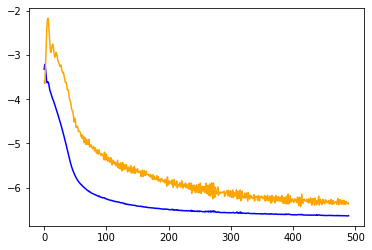

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][10:]),c='blue')
plt.plot(np.log(history.history['val_loss'][10:]),c='orange')

In [112]:
print(len(history.history['loss']))     #200
print(len(history.history['val_loss'])) #200

500
500


In [113]:
model.load_weights("cnn_2D-500epoch-GPU.mdl")

In [114]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

In [115]:
eq = tc[pd.to_datetime(indexes)]

In [116]:
gain = (eq.shift(-1) - eq) 
signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0


In [117]:
eq = (gain[signal])['2016':].cumsum()

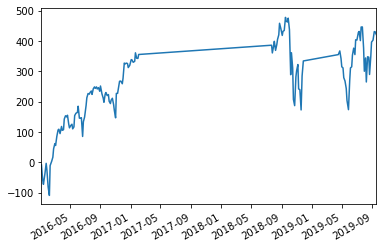

In [118]:
eq.plot()

In [119]:
eq.pct_change()[eq.pct_change() == eq.pct_change().max() ]

2016-01-29    7.714286
Name: SPFclose, dtype: float64

In [120]:
signal['2016':].astype(int).diff().abs().sum()

5.0

In [121]:
import pyfolio as pf 

In [122]:
# eq_relative = eq + tc[tc.index == eq.index[0]][0]
# tw_relative = tc[eq.index[0]:]
# plt.rcParams["figure.figsize"] = (20,10)
# """
#         plt.rcParams["figure.figsize"] = (20,10)
#         (hold*10).plot(label="hold")
        
#         eq=creturn
        
#         eq_relative = eq + tc[tc.index == eq.index[0]][0]
#         bm_relative = tc[eq.index[0]:]

#         eq_relative.plot(c="red",  label="BIAS strategy")
#         bm_relative.plot(c="blue", label="Buy & Hold" )
        
# #         creturn.plot(c="blue", label="BIAS strategy")
# #         (tc-tc[0]).plot(c="red", label="Buy & Hold")
#         plt.legend(loc='best')
# """
# eq_relative.plot(c="red",  label="CNN strategy")
# tw_relative.plot(c="blue", label="Buy & Hold")
# plt.legend(loc='best')
# eqpc = eq_relative.pct_change()
# bmpc = tw_relative.pct_change() 

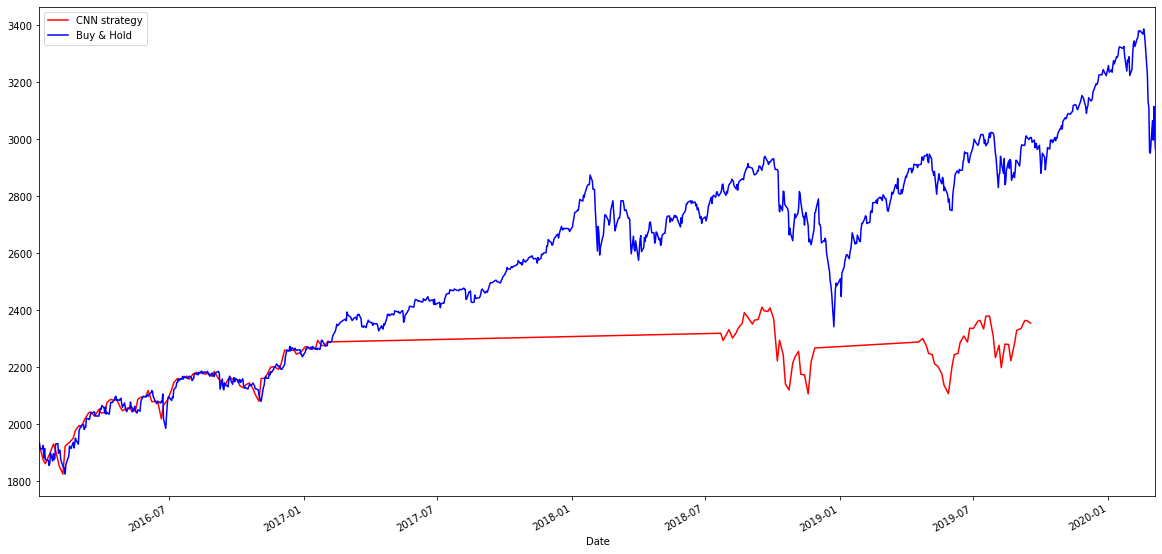

In [123]:
eq_relative = eq + tc[tc.index == eq.index[0]][0]
tw_relative = tc[eq.index[0]:]
plt.rcParams["figure.figsize"] = (20,10)
"""
        plt.rcParams["figure.figsize"] = (20,10)
        (hold*10).plot(label="hold")
        
        eq=creturn
        
        eq_relative = eq + tc[tc.index == eq.index[0]][0]
        bm_relative = tc[eq.index[0]:]

        eq_relative.plot(c="red",  label="BIAS strategy")
        bm_relative.plot(c="blue", label="Buy & Hold" )
        
#         creturn.plot(c="blue", label="BIAS strategy")
#         (tc-tc[0]).plot(c="red", label="Buy & Hold")
        plt.legend(loc='best')
"""
eq_relative.plot(c="red",  label="CNN strategy")
tw_relative.plot(c="blue", label="Buy & Hold")
plt.legend(loc='best')
eqpc = eq_relative.pct_change()
bmpc = tw_relative.pct_change() 

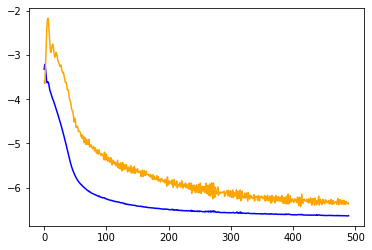

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][10:]),c='blue')
plt.plot(np.log(history.history['val_loss'][10:]),c='orange')

Start date,2016-01-07
End date,2019-09-18
Total months,7
,Backtest
Annual return,37.9%
Cumulative returns,22.3%
Annual volatility,26.3%
Sharpe ratio,1.36
Calmar ratio,3.00
Stability,0.66
Max drawdown,-12.6%


/home/liaw/anaconda3/envs/finlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.64,2018-09-17,2018-11-19,NaT,NaN
1,5.47,2016-01-26,2016-02-08,2016-02-17,17
2,4.79,2016-09-01,2016-11-01,2016-11-17,56
3,4.70,2016-06-03,2016-06-21,2016-07-05,23
4,3.32,2016-01-07,2016-01-15,2016-01-26,14


/home/liaw/anaconda3/envs/finlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


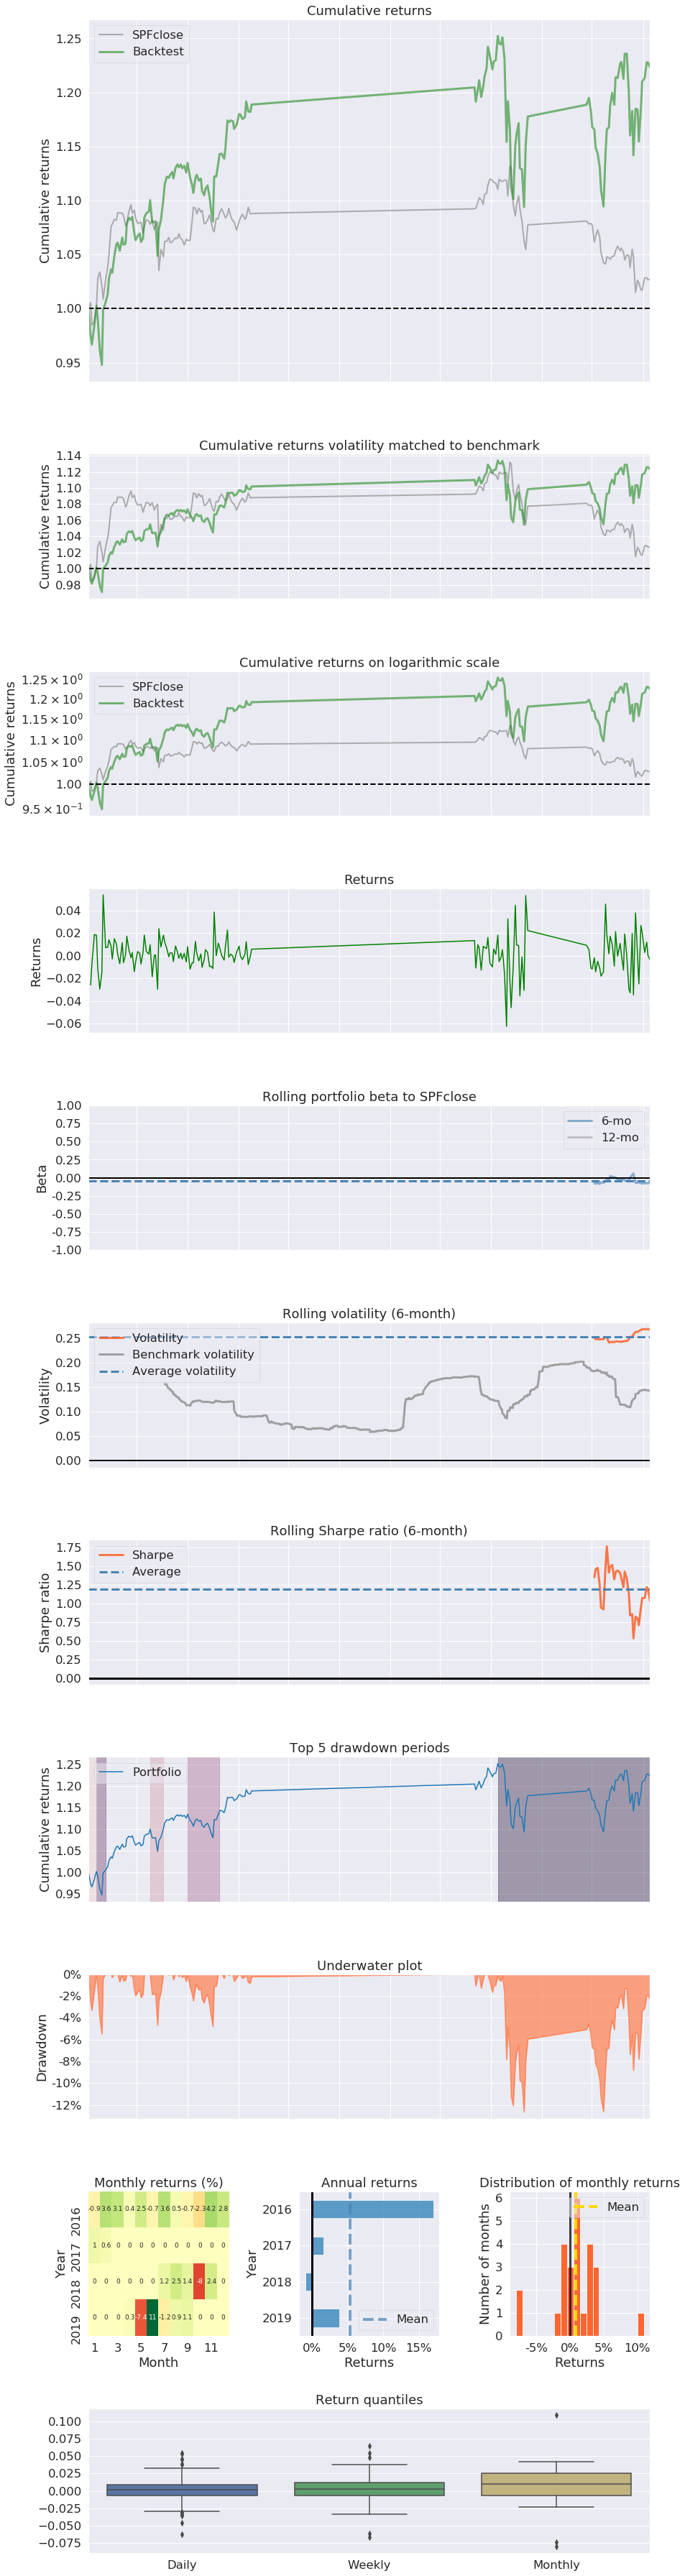

In [125]:
pf.create_returns_tear_sheet( eqpc, benchmark_rets=bmpc )  #relative

In [126]:
print("My program took ", time.time()-start_time, "to run")


My program took  27.628772974014282 to run
